# CoMD


---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-std=c99 -fopenmp -DDOUBLE -g -O3 -march=native -lm'
Run_Parameters = '-x 128 -y 128 -z 50'
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

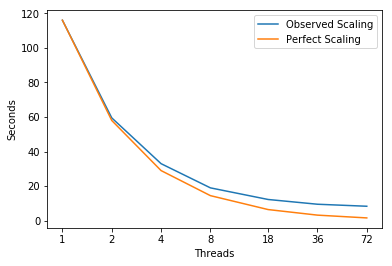

In [4]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[116.0, 59.5, 33.0, 19.0, 12.277777777777779, 9.527777777777779, 8.36111111111111],
        label='Observed Scaling')
ax.plot(Threads, [116.0, 58.0, 29.0, 14.5, 6.444444444444445, 3.2222222222222223, 1.6111111111111112],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                            |  100.0 %   |        1.5          |         0.5% |         54.1% |     44.3% |                0.60     |        1.0% |        0.7%  |       0.6%    |
| 72                           |  100.0 %   |        1.1          |         0.2% |         48.2% |     34.1% |                0.54     |        0.9% |        0.6%  |       1.9%    |

---
## ljForce( )
```c
145 int ljForce(SimFlat* s)
146 {
147    LjPotential* pot = (LjPotential *) s->pot;
148    real_t sigma = pot->sigma;
149    real_t epsilon = pot->epsilon;
150    real_t rCut = pot->cutoff;
151    real_t rCut2 = rCut*rCut;
152 
153    // zero forces and energy
154    real_t ePot = 0.0;
155    s->ePotential = 0.0;
156    int fSize = s->boxes->nTotalBoxes*MAXATOMS;
157    #pragma omp parallel for
158    for (int ii=0; ii<fSize; ++ii)
159    {
160       zeroReal3(s->atoms->f[ii]);
161       s->atoms->U[ii] = 0.;
162    }
163 
164    real_t s6 = sigma*sigma*sigma*sigma*sigma*sigma;
165 
166    real_t rCut6 = s6 / (rCut2*rCut2*rCut2);
167    real_t eShift = POT_SHIFT * rCut6 * (rCut6 - 1.0);
168 
169    int nNbrBoxes = 27;
170 
171    // loop over local boxes
172    #pragma omp parallel for reduction(+:ePot)
173    for (int iBox=0; iBox<s->boxes->nLocalBoxes; iBox++)
174    {
175       int nIBox = s->boxes->nAtoms[iBox];
176 
```
| loop at ljForce.c: 178 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                      |  94.3 %   |        1.6          |         0.2% |         37.2% |     31.7% |                0.60     |        0.5% |        0.2%  |       0.2%    |
| 72                     |  36.2 %   |        1.3          |         0.3% |         46.8% |     29.7% |                0.60     |        1.3% |        0.8%  |       2.3%    |
```c
177       // loop over neighbors of iBox
178       for (int jTmp=0; jTmp<nNbrBoxes; jTmp++)
179       {
180          int jBox = s->boxes->nbrBoxes[iBox][jTmp];
181 
182          assert(jBox>=0);
183 
184          int nJBox = s->boxes->nAtoms[jBox];
185 
186          // loop over atoms in iBox
187          for (int iOff=MAXATOMS*iBox; iOff<(iBox*MAXATOMS+nIBox); iOff++)
188          {
189
190             // loop over atoms in jBox
191             for (int jOff=jBox*MAXATOMS; jOff<(jBox*MAXATOMS+nJBox); jOff++)
192             {
193                real3 dr;
194                real_t r2 = 0.0;
195                for (int m=0; m<3; m++)
196                {
197                   dr[m] = s->atoms->r[iOff][m]-s->atoms->r[jOff][m];
198                   r2+=dr[m]*dr[m];
199                }
200 
201                if ( r2 <= rCut2 && r2 > 0.0)
202                {
203 
204                   // Important note:
205                   // from this point on r actually refers to 1.0/r
206                   r2 = 1.0/r2;
207                   real_t r6 = s6 * (r2*r2*r2);
208                   real_t eLocal = r6 * (r6 - 1.0) - eShift;
209                   s->atoms->U[iOff] += 0.5*eLocal;
210                   ePot += 0.5*eLocal;
211 
212                   // different formulation to avoid sqrt computation
213                   real_t fr = - 4.0*epsilon*r6*r2*(12.0*r6 - 6.0);
214                   for (int m=0; m<3; m++)
215                   {
216                      s->atoms->f[iOff][m] -= dr[m]*fr;
217                   }
218                }
219             } // loop over atoms in jBox
220          } // loop over atoms in iBox
221       } // loop over neighbor boxes
222    } // loop over local boxes in system
223 
224    ePot = ePot*4.0*epsilon;
225    s->ePotential = ePot;
226 
227    return 0;
228 }
```

Over Half time waiting in openMP lib for this run configuration